In [21]:
import tensorflow as tf
import numpy as np

In [48]:
fr=open('pose.txt','r')
TT=[]
for line in fr.readlines():
    line=line.split()
    line = list(map(eval, line))
    line = line[1:]
    t=np.array([line[:3]]).T
    q=line[3:]
    qq=[q[3],q[0],q[1],q[2]]
    R=quat2mat(qq)
    T=np.hstack((R,t))
    TT.append(T)

In [14]:
def norm_meshgrid(batch, height, width, is_homogeneous=True):
    """Construct a 2D meshgrid.
    Args:
        batch: batch size
        height: height of the grid
        width: width of the grid
        is_homogeneous: whether to return in homogeneous coordinates
    Returns:
        x,y grid coordinates [batch, 2 (3 if homogeneous), height, width]
    """
    x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                  tf.transpose(tf.expand_dims(
                      tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
    y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                  tf.ones(shape=tf.stack([1, width])))
    if is_homogeneous:
        ones = tf.ones_like(x_t)
        coords = tf.stack([x_t, y_t, ones], axis=0)
    else:
        coords = tf.stack([x_t, y_t], axis=0)
    coords = tf.tile(tf.expand_dims(coords, 0), [batch, 1, 1, 1])
    return coords,x_t,y_t

In [15]:
coords,x_t,y_t=norm_meshgrid(1, 5, 5, is_homogeneous=True)
coords

<tf.Tensor 'Tile_5:0' shape=(1, 3, 5, 5) dtype=float32>

In [16]:
with tf.Session() as sess:
    print(sess.run(coords))

[[[[-1.  -0.5  0.   0.5  1. ]
   [-1.  -0.5  0.   0.5  1. ]
   [-1.  -0.5  0.   0.5  1. ]
   [-1.  -0.5  0.   0.5  1. ]
   [-1.  -0.5  0.   0.5  1. ]]

  [[-1.  -1.  -1.  -1.  -1. ]
   [-0.5 -0.5 -0.5 -0.5 -0.5]
   [ 0.   0.   0.   0.   0. ]
   [ 0.5  0.5  0.5  0.5  0.5]
   [ 1.   1.   1.   1.   1. ]]

  [[ 1.   1.   1.   1.   1. ]
   [ 1.   1.   1.   1.   1. ]
   [ 1.   1.   1.   1.   1. ]
   [ 1.   1.   1.   1.   1. ]
   [ 1.   1.   1.   1.   1. ]]]]


In [18]:
with tf.Session() as sess:
    print(sess.run(y_t))

[[-1.  -1.  -1.  -1.  -1. ]
 [-0.5 -0.5 -0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   0. ]
 [ 0.5  0.5  0.5  0.5  0.5]
 [ 1.   1.   1.   1.   1. ]]


In [19]:
def quat2mat(q):
    ''' Calculate rotation matrix corresponding to quaternion

    Parameters
    ----------
    q : 4 element array-like

    Returns
    -------
    M : (3,3) array
      Rotation matrix corresponding to input quaternion *q*

    >>> import numpy as np
    >>> M = quat2mat([1, 0, 0, 0]) # Identity quaternion
    >>> np.allclose(M, np.eye(3))
    True
    >>> M = quat2mat([0, 1, 0, 0]) # 180 degree rotn around axis 0
    >>> np.allclose(M, np.diag([1, -1, -1]))
    True
    '''
    FLOAT_EPS = np.finfo(np.float).eps
    w, x, y, z = q
    Nq = w*w + x*x + y*y + z*z
    if Nq < FLOAT_EPS:
        return np.eye(3)
    s = 2.0/Nq
    X = x*s
    Y = y*s
    Z = z*s
    wX = w*X; wY = w*Y; wZ = w*Z
    xX = x*X; xY = x*Y; xZ = x*Z
    yY = y*Y; yZ = y*Z; zZ = z*Z
    return np.array(
           [[ 1.0-(yY+zZ), xY-wZ, xZ+wY ],
            [ xY+wZ, 1.0-(xX+zZ), yZ-wX ],
            [ xZ-wY, yZ+wX, 1.0-(xX+yY) ]])

In [65]:
def getC2TC1s(C1TW,C2TW):
    C1TW_R = C1TW[:,:3]
    C2TW_R = C2TW[:,:3]
    
    C1TW_t = np.expand_dims(C1TW[:,3], axis=1)
    C2TW_t = np.expand_dims(C2TW[:,3], axis=1)
    
    R=(np.linalg.inv(C1TW_R)).dot(C2TW_R)
    t=(np.linalg.inv(C1TW_R)).dot(C2TW_t-C1TW_t)
    
    T=np.hstack((R,t))
    return T

In [141]:
c2Tc1s=getC2TC1s(TT[0],TT[-1])

(480, 640)


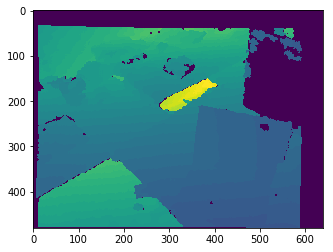

In [96]:
heatmaps2 = tf.gfile.FastGFile('./depth2.png','rb').read()
# heatmaps2 = tf.image.decode_jpeg(heatmaps2)  #Tensor

with tf.Session() as sess:
    image_data = tf.image.decode_jpeg(heatmaps2)

    image = sess.run(image_data)
    h,w,c=image.shape
    assert c==1
    image = image.reshape(h,w)
    plt.imshow(image)
    print(image.shape)

(480, 640)


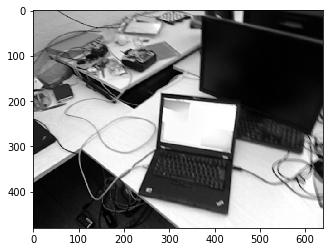

In [116]:
image_raw = tf.gfile.FastGFile('./color1.png','rb').read()

img = tf.image.decode_image(image_raw,channels=1)  #Tensor
img.set_shape([1,480,640,1])
with tf.Session() as sess:
    image = sess.run(img)
    h,w,c=image.shape

    image = image.reshape(h,w)
    plt.imshow(image,cmap='gray')
    print(image.shape)


In [175]:
heatmaps1_raw = tf.gfile.FastGFile('./color1.png','rb').read()
heatmaps1 = tf.image.decode_image(heatmaps1_raw,channels=1)  #Tensor
heatmaps1.set_shape([1,480,640,1])

heatmaps2_raw = tf.gfile.FastGFile('./color2.png','rb').read()
heatmaps2 = tf.image.decode_image(heatmaps2_raw,channels=1)  #Tensor
heatmaps2.set_shape([1,480,640,1])

depths1_raw = tf.gfile.FastGFile('./depth1.png','rb').read()
depths1 = tf.image.decode_image(depths1_raw,channels=1)  #Tensor
depths1.set_shape([1,480,640,1])

depths2_raw = tf.gfile.FastGFile('./depth2.png','rb').read()
depths2 = tf.image.decode_image(depths2_raw,channels=1)  #Tensor
depths2.set_shape([1,480,640,1])

In [122]:
K1=np.array([[517.3,0,318.6,0,516.5,255.3,0,0,1]]).reshape((1,3,3))

In [142]:
K1=tf.convert_to_tensor(K1, dtype=tf.float32)

In [143]:
c2Tc1s=tf.convert_to_tensor(np.array([c2Tc1s]), dtype=tf.float32)

In [144]:
bottom_row = tf.tile(tf.constant([0,0,0,1], dtype=tf.float32, shape=[1,1,4]), [1,1,1])
c2Tc1s = tf.concat([c2Tc1s, bottom_row], axis=1)
c2Tc1s

<tf.Tensor 'concat_4:0' shape=(1, 4, 4) dtype=float32>

In [148]:
with tf.Session() as sess:
    print(sess.run(c2Tc1s))

[[[ 0.9844775   0.11696012 -0.13085997 -0.05537799]
  [-0.11939117  0.9927879  -0.01086151 -0.02694579]
  [ 0.12864584  0.02631644  0.99134135  0.03818328]
  [ 0.          0.          0.          1.        ]]]


In [176]:
x,y,z=inverse_warp_view_2_to_1(heatmaps1, depths2, depths1, c2Tc1s, K1, None, None, None, depth_thresh=0.5, get_warped_depth=False)

In [170]:
x

<tf.Tensor 'WarpCoordinates_9/mul_8:0' shape=(1, 480, 640, 1) dtype=float32>

(480, 640)


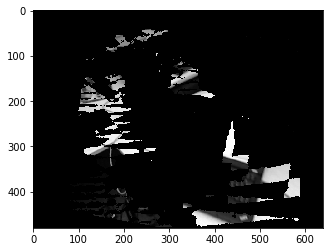

In [177]:
# x=x.set_shape([480,640])
with tf.Session() as sess:
    image = sess.run(x)
    u,h,w,c=image.shape

    image = image.reshape(h,w)
    plt.imshow(image,cmap='gray')
    print(image.shape)


(480, 640)


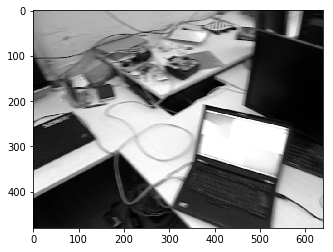

In [174]:
image_raw = tf.gfile.FastGFile('./color2.png','rb').read()

img = tf.image.decode_image(image_raw,channels=1)  #Tensor
img.set_shape([1,480,640,1])
with tf.Session() as sess:
    image = sess.run(img)
    h,w,c=image.shape

    image = image.reshape(h,w)
    plt.imshow(image,cmap='gray')
    print(image.shape)


In [162]:
def inverse_warp_view_2_to_1(heatmaps2, depths2, depths1, c2Tc1s, K1, K2, inv_thetas1, thetas2, depth_thresh=0.5, get_warped_depth=False):
    # compute warping xy coordinate from view1 to view2
    # Args
    #   depths1: [B,H,W,1] tf.float32
    #   c2Tc1s: [B,4,4] tf.float32
    #   K1,K2: [B,3,3] tf.float32
    #   inv_thetas1: [B,3,3] tf.float32
    #   thetas2: [B,3,3] tf.float32
    # Return
    #   heatmaps1w : [B,H,W,1] tf.float32 warped heatmaps from camera2 to camera1
    #   visible_masks1 : [B,H,W,1] tf.float32 visible masks on camera1
    #   xy_u2 : [B,H,W,2] tf.float32 xy-coords-maps from camera1 to camera2

    def norm_meshgrid(batch, height, width, is_homogeneous=True):
        """Construct a 2D meshgrid.
        Args:
            batch: batch size
            height: height of the grid
            width: width of the grid
            is_homogeneous: whether to return in homogeneous coordinates
        Returns:
            x,y grid coordinates [batch, 2 (3 if homogeneous), height, width]
        """
        x_t = tf.matmul(tf.ones(shape=tf.stack([height, 1])),
                      tf.transpose(tf.expand_dims(
                          tf.linspace(-1.0, 1.0, width), 1), [1, 0]))
        y_t = tf.matmul(tf.expand_dims(tf.linspace(-1.0, 1.0, height), 1),
                      tf.ones(shape=tf.stack([1, width])))
        if is_homogeneous:
            ones = tf.ones_like(x_t)
            coords = tf.stack([x_t, y_t, ones], axis=0)
        else:
            coords = tf.stack([x_t, y_t], axis=0)
        coords = tf.tile(tf.expand_dims(coords, 0), [batch, 1, 1, 1])
        return coords

    def norm_xy_coords(xyz, height, width):
        # xyz: [B,>=3,N], tf.float32 xyz[:,0] = x, xyz[:,1]=y
        # suppose 0<=x<width, 0<=y<height
        # outputs range will be [-1,1]
        x_t = tf.slice(xyz, [0,0,0], [-1,1,-1])
        y_t = tf.slice(xyz, [0,1,0], [-1,1,-1])
        z_t = tf.slice(xyz, [0,2,0], [-1,-1,-1])    
        x_t = 2 * (x_t / tf.cast(width-1,tf.float32)) - 1.0
        y_t = 2 * (y_t / tf.cast(height-1, tf.float32)) - 1.0
        n_xyz = tf.concat([x_t, y_t, z_t], axis=1)
        return n_xyz

    def unnorm_xy_coords(xyz, height, width):
        # xyz: [B,>=3,N], tf.float32 xyz[:,0] = x, xyz[:,1]=y
        # suppose -1<=x<=1, -1<=y<=1
        # outputs range will be [0,width) or [0,height)
        
        x_t = tf.slice(xyz, [0,0,0], [-1,1,-1])
        y_t = tf.slice(xyz, [0,1,0], [-1,1,-1])
        z_t = tf.slice(xyz, [0,2,0], [-1,-1,-1])    

        x_t = (x_t+1.0) * 0.5 * tf.cast(width-1, tf.float32)
        y_t = (y_t+1.0) * 0.5 * tf.cast(height-1, tf.float32)

        u_xyz = tf.concat([x_t, y_t, z_t], axis=1)
        return u_xyz

    with tf.name_scope('WarpCoordinates'):
        if K2 is None:
            K2 = K1 # use same intrinsic matrix

        eps = 1e-6
        batch_size = tf.shape(depths1)[0]
        height1 = tf.shape(depths1)[1]
        width1 = tf.shape(depths1)[2]

        inv_K1 = tf.matrix_inverse(K1)
        right_col = tf.zeros([batch_size,3,1], dtype=tf.float32)
        bottom_row = tf.tile(tf.constant([0,0,0,1], dtype=tf.float32, shape=[1,1,4]), [batch_size,1,1])
        K2_4x4 = tf.concat([K2, right_col], axis=2)
        K2_4x4 = tf.concat([K2_4x4, bottom_row], axis=1)

        xy_n1 = norm_meshgrid(batch_size, height1, width1) # [B,3,H,W]
        xy_n1 = tf.reshape(xy_n1, [batch_size, 3, -1]) # [B,3,N], N=H*W

        # Inverse inplane transformation on camera1
        if inv_thetas1 is not None:
            xy_n1 = tf.matmul(inv_thetas1, xy_n1)
            z_n1 = tf.slice(xy_n1, [0,2,0],[-1,1,-1])
            xy_n1 = xy_n1 / (z_n1+eps)

        # SE(3) transformation : pixel1 to camera1
        Z1 = tf.reshape(depths1, [batch_size, 1, -1])
        xy_u1 = unnorm_xy_coords(xy_n1, height=height1, width=width1)
        Z1=tf.cast(Z1, tf.float32)
        XYZ1 = tf.matmul(inv_K1, xy_u1) * Z1
        ones = tf.ones([batch_size, 1, height1*width1])
        XYZ1 = tf.concat([XYZ1, ones], axis=1)

        # SE(3) transformation : camera1 to camera2 to pixel2
        proj_T = tf.matmul(K2_4x4, c2Tc1s)
        xyz2 = tf.matmul(proj_T, XYZ1)
        z2 = tf.slice(xyz2, [0,2,0], [-1,1,-1])
        reproj_depths = tf.reshape(z2, [batch_size, 1, height1, width1])
        reproj_depths = tf.transpose(reproj_depths, perm=[0,2,3,1]) # [B,H,W,1]

        xy_u2 = tf.slice(xyz2, [0,0,0],[-1,3,-1]) / (z2+eps)

        # Inplane transformation on camera2
        if thetas2 is not None:
            xy_n2 = norm_xy_coords(xy_u2, height1, width1)
            xy_n2 = tf.matmul(thetas2, xy_n2)
            z_n2 = tf.slice(xy_n2,[0,2,0], [-1,1,-1])
            xy_n2 = xy_n2 / (z_n2+eps)
            xy_u2 = unnorm_xy_coords(xy_n2, height1, width1)
        xy_u2 = tf.slice(xy_u2, [0,0,0],[-1,2,-1]) # discard third dim
        xy_u2 = tf.reshape(xy_u2, [batch_size, 2, height1, width1])
        xy_u2 = tf.transpose(xy_u2, perm=[0, 2, 3, 1]) # [B,H,W,2]

        heatmaps1w, depths1w = bilinear_sampling(heatmaps2, xy_u2, depths2) # it is not correct way to check depth consistency but it works well practically 
        visible_masks = get_visibility_mask(xy_u2)
        camfront_masks = tf.cast(tf.greater(reproj_depths, tf.zeros((), reproj_depths.dtype)), tf.float32)
        depths1=tf.cast(depths1, tf.float32)
        nonocc_masks = tf.cast(tf.less(tf.squared_difference(depths1w, depths1), depth_thresh**2), tf.float32)
        visible_masks = visible_masks * camfront_masks * nonocc_masks # take logical_and
        heatmaps1w = heatmaps1w * visible_masks

        if get_warped_depth:
            return heatmaps1w, visible_masks, xy_u2, depths1w
        else:
            return heatmaps1w, visible_masks, xy_u2


In [91]:
def bilinear_sampling(photos, coords, depths=None):
    """Construct a new image by bilinear sampling from the input image.
    Points falling outside the source image boundary have value 0.
    Args:
        photos: source image to be sampled from [batch, height_s, width_s, channels]
        coords: coordinates of source pixels to sample from [batch, height_t,
          width_t, 2]. height_t/width_t correspond to the dimensions of the output
          image (don't need to be the same as height_s/width_s). The two channels
          correspond to x and y coordinates respectively.
    Returns:
        A new sampled image [batch, height_t, width_t, channels]
    """ 
    # photos: [batch_size, height2, width2, C]
    # coords: [batch_size, height1, width1, C]
    # depths: [batch_size, height2, width2, 1]
    def _repeat(x, n_repeats):
        rep = tf.transpose(
            tf.expand_dims(tf.ones(shape=tf.stack([
                n_repeats,
            ])), 1), [1, 0])
        rep = tf.cast(rep, 'float32')
        x = tf.matmul(tf.reshape(x, (-1, 1)), rep)
        return tf.reshape(x, [-1])

    with tf.name_scope('image_sampling'):
        coords_x, coords_y = tf.split(coords, [1, 1], axis=3)
        inp_size = tf.shape(photos)
        if depths is not None:
            dpt_size = tf.shape(depths)
        else:
            dpt_size = inp_size # dammy
        coord_size = tf.shape(coords)

        out_size = tf.stack([coord_size[0], 
                             coord_size[1],
                             coord_size[2],
                             inp_size[3],
                            ]) 
        out_size_d = tf.stack([coord_size[0], 
                             coord_size[1],
                             coord_size[2],
                             dpt_size[3],
                            ]) 
        
        coords_x = tf.cast(coords_x, 'float32')
        coords_y = tf.cast(coords_y, 'float32')

        x0 = tf.floor(coords_x)
        x1 = x0 + 1
        y0 = tf.floor(coords_y)
        y1 = y0 + 1

        y_max = tf.cast(tf.shape(photos)[1] - 1, 'float32')
        x_max = tf.cast(tf.shape(photos)[2] - 1, 'float32')
        zero = tf.zeros([1], dtype='float32')

        x0_safe = tf.clip_by_value(x0, zero, x_max)
        y0_safe = tf.clip_by_value(y0, zero, y_max)
        x1_safe = tf.clip_by_value(x1, zero, x_max)
        y1_safe = tf.clip_by_value(y1, zero, y_max)

        ## bilinear interp weights, with points outside the grid having weight 0
        # wt_x0 = (x1 - coords_x) * tf.cast(tf.equal(x0, x0_safe), 'float32')
        # wt_x1 = (coords_x - x0) * tf.cast(tf.equal(x1, x1_safe), 'float32')
        # wt_y0 = (y1 - coords_y) * tf.cast(tf.equal(y0, y0_safe), 'float32')
        # wt_y1 = (coords_y - y0) * tf.cast(tf.equal(y1, y1_safe), 'float32')

        wt_x0 = x1_safe - coords_x
        wt_x1 = coords_x - x0_safe
        wt_y0 = y1_safe - coords_y
        wt_y1 = coords_y - y0_safe

        ## indices in the flat image to sample from
        dim2 = tf.cast(inp_size[2], 'float32')
        dim1 = tf.cast(inp_size[2] * inp_size[1], 'float32')
        base = tf.reshape(
            _repeat(
                tf.cast(tf.range(coord_size[0]), 'float32') * dim1,
                coord_size[1] * coord_size[2]),
            [out_size[0], out_size[1], out_size[2], 1])

        base_y0 = base + y0_safe * dim2
        base_y1 = base + y1_safe * dim2
        idx00 = tf.reshape(x0_safe + base_y0, [-1])
        idx01 = x0_safe + base_y1
        idx10 = x1_safe + base_y0
        idx11 = x1_safe + base_y1

        
        ## sample from photos
        photos_flat = tf.reshape(photos, tf.stack([-1, inp_size[3]]))
        photos_flat = tf.cast(photos_flat, 'float32')

        im00 = tf.reshape(tf.gather(photos_flat, tf.cast(idx00, 'int32')), out_size)
        im01 = tf.reshape(tf.gather(photos_flat, tf.cast(idx01, 'int32')), out_size)
        im10 = tf.reshape(tf.gather(photos_flat, tf.cast(idx10, 'int32')), out_size)
        im11 = tf.reshape(tf.gather(photos_flat, tf.cast(idx11, 'int32')), out_size)

        w00 = wt_x0 * wt_y0
        w01 = wt_x0 * wt_y1
        w10 = wt_x1 * wt_y0
        w11 = wt_x1 * wt_y1

        out_photos = tf.add_n([
            w00 * im00, w01 * im01,
            w10 * im10, w11 * im11
        ])
        if depths is None:
            return out_photos
        else:
            ## sample from depths
            dpts_flat = tf.reshape(depths, tf.stack([-1, dpt_size[3]]))
            dpts_flat = tf.cast(dpts_flat, 'float32')
            
            dp00 = tf.reshape(tf.gather(dpts_flat, tf.cast(idx00, 'int32')), out_size_d)
            dp01 = tf.reshape(tf.gather(dpts_flat, tf.cast(idx01, 'int32')), out_size_d)
            dp10 = tf.reshape(tf.gather(dpts_flat, tf.cast(idx10, 'int32')), out_size_d)
            dp11 = tf.reshape(tf.gather(dpts_flat, tf.cast(idx11, 'int32')), out_size_d)

            out_depth = tf.add_n([
                w00 * dp00, w01 * dp01,
                w10 * dp10, w11 * dp11
            ])

            return out_photos, out_depth


In [100]:
def get_visibility_mask(coords):
    """ Get visible region mask
    Args:
        coords: [batch, height, width, 2]
    Return:
        visible mask [batch, height, width, 1]
    """

    coords_x, coords_y = tf.split(coords, [1, 1], axis=3)

    coords_x = tf.cast(coords_x, 'float32')
    coords_y = tf.cast(coords_y, 'float32')

    x0 = tf.cast(tf.floor(coords_x), tf.int32)
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(coords_y), tf.int32)
    y1 = y0 + 1

    height = tf.shape(coords)[1]
    width = tf.shape(coords)[2]
    zero = tf.zeros([1], dtype=tf.int32)
    inside_x = tf.logical_and(tf.greater_equal(x0, zero), tf.less(x1, width))
    inside_y = tf.logical_and(tf.greater_equal(y0, zero), tf.less(y1, height))
    visible_mask = tf.cast(tf.logical_and(inside_x, inside_y), tf.float32)

    return visible_mask
